### Prepare data

In [1]:
import pandas as pd
import pickle
import numpy as np

In [2]:
# 读取原始数据（假设每个诊断记录为一行）
clinical_df = pd.read_csv("../Data/ICD10_long.csv")

In [3]:
clinical_df.shape

(7015554, 5)

In [4]:
clinical_df['eid'] = clinical_df['eid'].astype(str)

In [5]:
clinical_df.head(2)

,eid,ICD10_codes,Date,p40000_i0,p40023
0,1000122,J383,1999-07-06,2014-12-22,1.0
1,1000122,M255,2001-07-31,2014-12-22,1.0


In [6]:
len(clinical_df['ICD10_codes'].unique())

12315

In [7]:
clinical_df.dtypes

eid             object
ICD10_codes     object
Date            object
p40000_i0       object
p40023         float64
dtype: object

In [8]:
len(set(clinical_df['eid']))

446802

In [9]:
Olink_df = pd.read_csv("../Data/Olink.csv")

In [10]:
Olink_df['olink_instance_0.eid'] = Olink_df['olink_instance_0.eid'].astype(str)

In [11]:
Olink_df.head(2)

,olink_instance_0.eid,olink_instance_0.a1bg,olink_instance_0.aamdc,olink_instance_0.aarsd1,olink_instance_0.abca2,olink_instance_0.abhd14b,olink_instance_0.abl1,olink_instance_0.abo,olink_instance_0.abraxas2,olink_instance_0.acaa1,...,olink_instance_0.zfyve19,olink_instance_0.zhx2,olink_instance_0.znf174,olink_instance_0.znf75d,olink_instance_0.znf830,olink_instance_0.znrd2,olink_instance_0.znrf4,olink_instance_0.zp3,olink_instance_0.zp4,olink_instance_0.zpr1
0,1002133,0.0957,0.59795,1.33215,-0.6441,0.76325,0.3784,0.5446,0.4682,0.21920,...,-0.2728,0.1954,-0.2586,-0.0127,0.0235,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,1002201,-0.0473,0.39585,0.26585,0.0604,1.07765,1.3977,0.5830,1.0740,0.75625,...,0.9153,-0.0274,-0.3048,-0.8814,-0.5342,1.12255,-0.5537,-5.1443,-0.1713,-0.5605


In [12]:
Olink_df = Olink_df.rename(columns={'olink_instance_0.eid': 'eid'})

In [13]:
Olink_df.head(4)

,eid,olink_instance_0.a1bg,olink_instance_0.aamdc,olink_instance_0.aarsd1,olink_instance_0.abca2,olink_instance_0.abhd14b,olink_instance_0.abl1,olink_instance_0.abo,olink_instance_0.abraxas2,olink_instance_0.acaa1,...,olink_instance_0.zfyve19,olink_instance_0.zhx2,olink_instance_0.znf174,olink_instance_0.znf75d,olink_instance_0.znf830,olink_instance_0.znrd2,olink_instance_0.znrf4,olink_instance_0.zp3,olink_instance_0.zp4,olink_instance_0.zpr1
0,1002133,0.0957,0.59795,1.33215,-0.6441,0.76325,0.3784,0.5446,0.4682,0.21920,...,-0.2728,0.1954,-0.2586,-0.0127,0.02350,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,1002201,-0.0473,0.39585,0.26585,0.0604,1.07765,1.3977,0.5830,1.0740,0.75625,...,0.9153,-0.0274,-0.3048,-0.8814,-0.53420,1.12255,-0.5537,-5.1443,-0.1713,-0.5605
2,1002534,-0.2239,-0.04545,-0.07580,0.2499,-0.48380,0.4578,-0.0678,-0.1641,-0.29010,...,-0.8164,0.2514,0.4768,-0.4894,-0.21715,0.00550,-0.0715,-5.9309,-0.2436,-0.4368
3,1003548,0.0255,NaN,NaN,NaN,NaN,NaN,-0.2824,NaN,NaN,...,1.1505,0.1681,0.2402,NaN,0.42805,0.55870,0.4882,NaN,-0.0600,0.7822


In [14]:
Olink_df.shape

(53013, 2924)

In [15]:
# 提取非eid列（蛋白质表达量列）
protein_cols = Olink_df.columns[1:]  # 第一列是eid

In [16]:
# 找出蛋白质表达量全为NaN的病人行
all_nan_mask = Olink_df[protein_cols].isna().all(axis=1)

In [17]:
# 过滤掉全NaN的病人
Olink_df_filtered = Olink_df[~all_nan_mask].copy()

In [18]:
Olink_df_filtered.shape

(53013, 2924)

In [19]:
# 2. 用各列最小值填补NaN
# 计算各列最小值（排除NaN）
col_min_values = Olink_df_filtered[protein_cols].min()

# 填补NaN（使用广播机制）
Olink_df_imputed = Olink_df_filtered.copy()
Olink_df_imputed[protein_cols] = Olink_df_filtered[protein_cols].fillna(col_min_values)

In [20]:
Olink_df_imputed.head(4)

,eid,olink_instance_0.a1bg,olink_instance_0.aamdc,olink_instance_0.aarsd1,olink_instance_0.abca2,olink_instance_0.abhd14b,olink_instance_0.abl1,olink_instance_0.abo,olink_instance_0.abraxas2,olink_instance_0.acaa1,...,olink_instance_0.zfyve19,olink_instance_0.zhx2,olink_instance_0.znf174,olink_instance_0.znf75d,olink_instance_0.znf830,olink_instance_0.znrd2,olink_instance_0.znrf4,olink_instance_0.zp3,olink_instance_0.zp4,olink_instance_0.zpr1
0,1002133,0.0957,0.59795,1.33215,-0.6441,0.76325,0.37840,0.5446,0.4682,0.21920,...,-0.2728,0.1954,-0.2586,-0.0127,0.02350,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,1002201,-0.0473,0.39585,0.26585,0.0604,1.07765,1.39770,0.5830,1.0740,0.75625,...,0.9153,-0.0274,-0.3048,-0.8814,-0.53420,1.12255,-0.5537,-5.1443,-0.1713,-0.5605
2,1002534,-0.2239,-0.04545,-0.07580,0.2499,-0.48380,0.45780,-0.0678,-0.1641,-0.29010,...,-0.8164,0.2514,0.4768,-0.4894,-0.21715,0.00550,-0.0715,-5.9309,-0.2436,-0.4368
3,1003548,0.0255,-1.97485,-4.52005,-1.5961,-5.09210,-2.67535,-0.2824,-2.4128,-6.44710,...,1.1505,0.1681,0.2402,-5.0317,0.42805,0.55870,0.4882,-7.2245,-0.0600,0.7822


In [21]:
# 将数据框从宽格式转换为长格式
Olink_long_df = pd.melt(Olink_df_imputed, id_vars=['eid'], var_name='protein_name', value_name='protein_expression')

print(Olink_long_df)  

               eid           protein_name  protein_expression
0          1002133  olink_instance_0.a1bg              0.0957
1          1002201  olink_instance_0.a1bg             -0.0473
2          1002534  olink_instance_0.a1bg             -0.2239
3          1003548  olink_instance_0.a1bg              0.0255
4          1003599  olink_instance_0.a1bg              0.2003
...            ...                    ...                 ...
154956994  6021692  olink_instance_0.zpr1              1.2116
154956995  6021914  olink_instance_0.zpr1             -0.0460
154956996  6022081  olink_instance_0.zpr1             -0.6499
154956997  6022213  olink_instance_0.zpr1             -0.1758
154956998  6022247  olink_instance_0.zpr1              1.4512

[154956999 rows x 3 columns]


In [22]:
53013 * 2923

154956999

In [23]:
print(Olink_long_df['protein_expression'].min())
print(Olink_long_df['protein_expression'].max())

-9.66045
13.4435


In [24]:
Olink_long_df['protein_expression'].describe()

count    1.549570e+08
mean    -2.591068e-01
std      1.175336e+00
min     -9.660450e+00
25%     -4.430000e-01
50%     -5.570000e-02
75%      2.548500e-01
max      1.344350e+01
Name: protein_expression, dtype: float64

In [25]:
Olink_long_df = Olink_long_df.dropna(subset=['protein_expression'])

In [26]:
Olink_long_df.shape

(154956999, 3)

In [27]:
NMR_df = pd.read_csv("../Data/NMR.csv")

In [28]:
NMR_df.shape

(502131, 252)

In [29]:
NMR_df['participant.eid'] = NMR_df['participant.eid'].astype(str)

In [30]:
NMR_df.head(2)

,participant.eid,participant.p20280_i0,participant.p20281_i0,participant.p23400_i0,participant.p23401_i0,participant.p23402_i0,participant.p23403_i0,participant.p23404_i0,participant.p23405_i0,participant.p23406_i0,...,participant.p23639_i0,participant.p23640_i0,participant.p23641_i0,participant.p23642_i0,participant.p23643_i0,participant.p23644_i0,participant.p23645_i0,participant.p23646_i0,participant.p23647_i0,participant.p23648_i0
0,1000053,2.9721,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,...,49.941,40.646,33.031,7.6145,9.413,58.373,34.427,24.479,9.9478,7.2007
1,1000122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
NMR_df = NMR_df.rename(columns={'participant.eid': 'eid'})

In [32]:
NMR_df.head(4)

,eid,participant.p20280_i0,participant.p20281_i0,participant.p23400_i0,participant.p23401_i0,participant.p23402_i0,participant.p23403_i0,participant.p23404_i0,participant.p23405_i0,participant.p23406_i0,...,participant.p23639_i0,participant.p23640_i0,participant.p23641_i0,participant.p23642_i0,participant.p23643_i0,participant.p23644_i0,participant.p23645_i0,participant.p23646_i0,participant.p23647_i0,participant.p23648_i0
0,1000053,2.97210,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,...,49.941,40.646,33.031,7.6145,9.4130,58.373,34.427,24.479,9.9478,7.2007
1,1000122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000148,5.79763,0.407074,6.5412,4.7789,2.1906,0.94260,3.9233,2.5883,1.76230,...,46.042,50.345,40.931,9.4135,3.6133,56.367,40.318,29.758,10.5600,3.3156
3,1000150,5.32703,0.436711,4.2633,3.1027,1.4863,0.82748,1.9775,1.6164,1.16060,...,49.781,40.044,32.094,7.9500,10.1750,58.825,32.954,23.077,9.8765,8.2210


In [33]:
# 提取非eid列
NMR_cols = NMR_df.columns[1:]  # 第一列是eid

In [34]:
# 找出表达量全为NaN的病人行
all_nan_mask = NMR_df[NMR_cols].isna().all(axis=1)

In [35]:
# 过滤掉全NaN的病人
NMR_df_filtered = NMR_df[~all_nan_mask].copy()

In [36]:
NMR_df_filtered.shape

(274236, 252)

In [37]:
# 2. 用各列最小值填补NaN
# 计算各列最小值（排除NaN）
col_min_values = NMR_df_filtered[NMR_cols].min()

# 填补NaN（使用广播机制）
NMR_df_imputed = NMR_df_filtered.copy()
NMR_df_imputed[NMR_cols] = NMR_df_filtered[NMR_cols].fillna(col_min_values)

In [38]:
NMR_df_imputed.head(4)

,eid,participant.p20280_i0,participant.p20281_i0,participant.p23400_i0,participant.p23401_i0,participant.p23402_i0,participant.p23403_i0,participant.p23404_i0,participant.p23405_i0,participant.p23406_i0,...,participant.p23639_i0,participant.p23640_i0,participant.p23641_i0,participant.p23642_i0,participant.p23643_i0,participant.p23644_i0,participant.p23645_i0,participant.p23646_i0,participant.p23647_i0,participant.p23648_i0
0,1000053,2.97210,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,...,49.941,40.646,33.031,7.6145,9.4130,58.373,34.427,24.479,9.9478,7.2007
2,1000148,5.79763,0.407074,6.5412,4.7789,2.1906,0.94260,3.9233,2.5883,1.76230,...,46.042,50.345,40.931,9.4135,3.6133,56.367,40.318,29.758,10.5600,3.3156
3,1000150,5.32703,0.436711,4.2633,3.1027,1.4863,0.82748,1.9775,1.6164,1.16060,...,49.781,40.044,32.094,7.9500,10.1750,58.825,32.954,23.077,9.8765,8.2210
5,1000199,5.73236,0.384780,5.8360,3.8974,1.8090,0.81030,3.0389,2.0885,1.93860,...,46.181,48.841,39.874,8.9677,4.9780,58.066,37.815,28.076,9.7397,4.1188


In [39]:
# 将数据框从宽格式转换为长格式
NMR_long_df = pd.melt(NMR_df_imputed, id_vars=['eid'], var_name='NMR_name', value_name='NMR_expression')

print(NMR_long_df)  

              eid               NMR_name  NMR_expression
0         1000053  participant.p20280_i0         2.97210
1         1000148  participant.p20280_i0         5.79763
2         1000150  participant.p20280_i0         5.32703
3         1000199  participant.p20280_i0         5.73236
4         1000428  participant.p20280_i0         5.26226
...           ...                    ...             ...
68833231  6022081  participant.p23648_i0         5.61880
68833232  6022102  participant.p23648_i0         5.26160
68833233  6022141  participant.p23648_i0         4.78620
68833234  6022197  participant.p23648_i0         3.85360
68833235  6022252  participant.p23648_i0         5.26830

[68833236 rows x 3 columns]


In [40]:
NMR_df_imputed.shape

(274236, 252)

In [41]:
274236 * 251

68833236

In [42]:
# 移除 NMR_expression 列中值为 NaN 的行
NMR_long_df = NMR_long_df.dropna(subset=['NMR_expression'])

print(NMR_long_df) 

              eid               NMR_name  NMR_expression
0         1000053  participant.p20280_i0         2.97210
1         1000148  participant.p20280_i0         5.79763
2         1000150  participant.p20280_i0         5.32703
3         1000199  participant.p20280_i0         5.73236
4         1000428  participant.p20280_i0         5.26226
...           ...                    ...             ...
68833231  6022081  participant.p23648_i0         5.61880
68833232  6022102  participant.p23648_i0         5.26160
68833233  6022141  participant.p23648_i0         4.78620
68833234  6022197  participant.p23648_i0         3.85360
68833235  6022252  participant.p23648_i0         5.26830

[68833236 rows x 3 columns]


In [43]:
len(set(clinical_df['eid'])&set(Olink_df_imputed['eid'])&set(NMR_df_imputed['eid']))

27295

In [44]:
len(set(clinical_df['eid'])&set(Olink_df_imputed['eid']))

47626

In [45]:
len(set(clinical_df['eid'])&set(NMR_df_imputed['eid']))

244823

In [46]:
len(set(Olink_df_imputed['eid'])&set(NMR_df_imputed['eid']))

30294

In [47]:
# 筛选出 clinical_df 中 eid 也存在于 Olink 的 eid 列中的行
subset_clinical_df = clinical_df[clinical_df['eid'].isin(Olink_long_df['eid'])]

In [48]:
subset_clinical_df.shape

(805376, 5)

In [49]:
# 筛选出 clinical_df 中 eid 也存在于 NMR 的 eid 列中的行
subset_clinical_df = subset_clinical_df[subset_clinical_df['eid'].isin(NMR_long_df['eid'])]

In [50]:
subset_clinical_df.shape

(474560, 5)

In [51]:
subset_clinical_df.head(2)

,eid,ICD10_codes,Date,p40000_i0,p40023
743,1002133,I802,2003-04-02,NaN,NaN
744,1002133,M1997,2009-04-17,NaN,NaN


In [52]:
subset_clinical_df = subset_clinical_df.drop(columns=['Date', 'p40000_i0', 'p40023'])

In [53]:
subset_clinical_df['relationship'] = 1

In [54]:
subset_clinical_df.head(2)

,eid,ICD10_codes,relationship
743,1002133,I802,1
744,1002133,M1997,1


In [55]:
# 保存为以制表符分隔的文本文件
file_path = '../Data/subset_ICD10_in_Olink_long.txt'
subset_clinical_df.to_csv(file_path, sep='\t', na_rep='nan', index=False)

In [56]:
subset_Olink_long_df = Olink_long_df[Olink_long_df['eid'].isin(subset_clinical_df['eid'])]

In [57]:
subset_Olink_long_df.head(2)

,eid,protein_name,protein_expression
0,1002133,olink_instance_0.a1bg,0.0957
1,1002201,olink_instance_0.a1bg,-0.0473


In [58]:
# 按 eid 分组，对每个分组内按 protein_expression 降序排序
sorted_Olink_df = subset_Olink_long_df.sort_values(['eid', 'protein_expression'], ascending=[True, False])

In [59]:
# 对每个分组保留前 20 行
result_Olink_df = sorted_Olink_df.groupby('eid').head(20)

print(result_Olink_df)

               eid             protein_name  protein_expression
19805682   1000021   olink_instance_0.ccar2             9.35690
103884300  1000021    olink_instance_0.paep             4.74010
121378590  1000021    olink_instance_0.rln2             4.67330
88775595   1000021  olink_instance_0.mapre3             4.55670
54476184   1000021    olink_instance_0.fdx2             3.96610
...            ...                      ...                 ...
57529623   6022412    olink_instance_0.fshb             2.23315
135829824  6022412   olink_instance_0.ssc4d             2.22095
59013987   6022412  olink_instance_0.galnt3             2.11620
81173421   6022412   olink_instance_0.krt18             2.09060
15384288   6022412    olink_instance_0.bst2             2.05680

[545900 rows x 3 columns]


In [60]:
result_Olink_df.shape

(545900, 3)

In [61]:
len(result_Olink_df['eid'].unique())

27295

In [62]:
subset_NMR_long_df = NMR_long_df[NMR_long_df['eid'].isin(subset_clinical_df['eid'])]

In [63]:
len(subset_NMR_long_df['eid'].unique())

27295

In [64]:
subset_NMR_long_df.head(2)

,eid,NMR_name,NMR_expression
26,1002133,participant.p20280_i0,4.06436
28,1002201,participant.p20280_i0,5.62458


In [65]:
# 按 eid 分组，对每个分组内按 NMR_expression 降序排序
sorted_NMR_df = subset_NMR_long_df.sort_values(['eid', 'NMR_expression'], ascending=[True, False])

# 对每个分组保留前 10 行
result_NMR_df = sorted_NMR_df.groupby('eid').head(10)

print(result_NMR_df)

              eid               NMR_name  NMR_expression
50897992  1000021  participant.p23583_i0          87.447
59673544  1000021  participant.p23615_i0          73.625
53640352  1000021  participant.p23593_i0          73.483
58302364  1000021  participant.p23610_i0          71.083
61044724  1000021  participant.p23620_i0          68.700
...           ...                    ...             ...
67516797  6022412  participant.p23644_i0          57.697
52159581  6022412  participant.p23588_i0          57.677
54901941  6022412  participant.p23598_i0          55.153
59838189  6022412  participant.p23616_i0          53.509
53530761  6022412  participant.p23593_i0          52.855

[272950 rows x 3 columns]


In [66]:
len(subset_NMR_long_df['eid'].unique())

27295

In [67]:
subset_clinical_df = subset_clinical_df.rename(columns={'eid': 'node1'})
subset_clinical_df = subset_clinical_df.rename(columns={'ICD10_codes': 'node2'})

# subset_Olink_long_df = subset_Olink_long_df.rename(columns={'eid': 'node1'})
# subset_Olink_long_df = subset_Olink_long_df.rename(columns={'protein_name': 'node2'})
# subset_Olink_long_df = subset_Olink_long_df.rename(columns={'protein_expression': 'relationship'})

# subset_NMR_long_df = subset_NMR_long_df.rename(columns={'eid': 'node1'})
# subset_NMR_long_df = subset_NMR_long_df.rename(columns={'NMR_name': 'node2'})
# subset_NMR_long_df = subset_NMR_long_df.rename(columns={'NMR_expression': 'relationship'})

result_Olink_df = result_Olink_df.rename(columns={'eid': 'node1'})
result_Olink_df = result_Olink_df.rename(columns={'protein_name': 'node2'})
result_Olink_df = result_Olink_df.rename(columns={'protein_expression': 'relationship'})

result_NMR_df = result_NMR_df.rename(columns={'eid': 'node1'})
result_NMR_df = result_NMR_df.rename(columns={'NMR_name': 'node2'})
result_NMR_df = result_NMR_df.rename(columns={'NMR_expression': 'relationship'})

In [68]:
# 合并三个数据框
# merged_df = pd.concat([subset_clinical_df, subset_Olink_long_df, subset_NMR_long_df], ignore_index=True)
merged_df = pd.concat([subset_clinical_df, result_Olink_df, result_NMR_df], ignore_index=True)
print(merged_df)

           node1                  node2  relationship
0        1002133                   I802         1.000
1        1002133                  M1997         1.000
2        1002133                   M201         1.000
3        1002133                   M798         1.000
4        1002133                   D120         1.000
...          ...                    ...           ...
1293405  6022412  participant.p23644_i0        57.697
1293406  6022412  participant.p23588_i0        57.677
1293407  6022412  participant.p23598_i0        55.153
1293408  6022412  participant.p23616_i0        53.509
1293409  6022412  participant.p23593_i0        52.855

[1293410 rows x 3 columns]


In [69]:
type(merged_df.iat[0,0])

str

In [70]:
# 保存为以制表符分隔的文本文件
file_path = '../Data/merged_df_long.txt'
merged_df.to_csv(file_path, sep='\t', na_rep='nan', index=False)

In [71]:
merged_df = pd.read_csv('../Data/merged_df_long.txt', sep='\t')

merged_df.head(2)

,node1,node2,relationship
0,1002133,I802,1.0
1,1002133,M1997,1.0


In [72]:
merged_df['node1'] = merged_df['node1'].astype(str)

## read in embeddings

In [73]:
import pickle
import numpy as np

In [74]:
print(np.__version__)

1.26.4


In [75]:
with open('../Data/gpt_protein_embeddings_dict.pkl', 'rb') as f:
    protein_embeddings_dict = pickle.load(f)

In [76]:
with open('../Data/gpt_embeddings_dict.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

In [77]:
with open('../Data/metabolite_embeddings_dict.pkl', 'rb') as f:
    metabolite_embeddings_dict = pickle.load(f)

## ICD10 embedding

In [78]:
import glob
import json
import string

In [79]:
values = []
icd_index = []
for index in list(string.ascii_uppercase):
    file = glob.glob(f'../Data/icd10_embedding/{index}/icd10_results_*.json')[0]
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
        for key, value in data['embeddings'].items():
            values.append(value)
            icd_index.append(key)

embeddings = np.array(values)

In [80]:
icd_index[0:3]

['A00', 'A00.0', 'A00.1']

In [81]:
icd10_embeddings = {}

for index in string.ascii_uppercase:
    try:
        file = glob.glob(f'../Data/icd10_embedding/{index}/icd10_results_*.json')[0]
        
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            
            # 处理每个键，移除小数点后再添加到总字典
            for key, value in data['embeddings'].items():
                clean_key = key.replace('.', '')  # 移除小数点
                icd10_embeddings[clean_key] = value
                
    except (IndexError, FileNotFoundError):
        print(f"未找到字母 {index} 对应的文件")
    except Exception as e:
        print(f"处理字母 {index} 时出错: {e}")

In [82]:
type(icd10_embeddings)

dict

In [83]:
# 检查键是否存在
if "C926" in icd10_embeddings:
    print("键存在于字典中")
else:
    print("键不存在于字典中")

键存在于字典中


In [84]:
with open('../Data/icd10_embeddings_dict.pkl', 'wb') as f:
    pickle.dump(icd10_embeddings, f)

## get the order of nodes

In [85]:
merged_df['node2'] = merged_df['node2'].str.replace("olink_instance_0.", "", regex=False)

merged_df['node2'] = merged_df['node2'].str.replace("participant.", "", regex=False)

In [86]:
NMR_name_description_mapping = pd.read_csv('../Data/NMR_name_description_mapping.csv',
                                           encoding='utf-8')

In [87]:
NMR_name_description_mapping.head(2)

,NMR_name,full_name
0,p20280_i0,Glucose-lactate | Instance 0
1,p20281_i0,Spectrometer-corrected alanine | Instance 0


In [88]:
NMR_name_description_mapping['full_name'] = NMR_name_description_mapping['full_name'].str.replace(" | Instance 0", "", regex=False)

In [89]:
NMR_name_description_mapping.head(2)

,NMR_name,full_name
0,p20280_i0,Glucose-lactate
1,p20281_i0,Spectrometer-corrected alanine


In [90]:
# 创建一个映射字典
name_mapping = dict(zip(NMR_name_description_mapping['NMR_name'], 
                        NMR_name_description_mapping['full_name']))

In [91]:
# 定义一个函数来执行映射
def map_node2(name):
    return name_mapping.get(name, name)  # 如果找不到映射，返回原值

In [92]:
# 应用映射到node2列
merged_df['node2'] = merged_df['node2'].apply(map_node2)

In [93]:
# 查看结果
print(merged_df.head(2))
print(merged_df.tail(2))

     node1  node2  relationship
0  1002133   I802           1.0
1  1002133  M1997           1.0
           node1                                              node2  \
1293408  6022412  Cholesteryl Esters to Total Lipids in Large LD...   
1293409  6022412  Triglycerides to Total Lipids in Large VLDL pe...   

         relationship  
1293408        53.509  
1293409        52.855  


## get KNN

In [94]:
import numpy as np
from sklearn.metrics import pairwise_distances
from typing import List, Optional, Dict, Tuple
from scipy.stats import spearmanr

In [95]:
def get_knn( # 不包含自己
    embeddings: np.ndarray,
    names: List[str],
    metric: str,
    k: int,
    threshold: Optional[float] = None
) -> Dict[str, List[Tuple[str, float]]]:
    if metric=='spearman':
        corr_matrix, _ = spearmanr(embeddings, axis=1) #axis=1 means rows
        dists = 1.0 - np.abs(corr_matrix)
    else:
        dists = pairwise_distances(embeddings, metric=metric)
    n = len(names)
    result: Dict[str, List[Tuple[str, float]]] = {}
    for i, name in enumerate(names):
        dist_row = dists[i]
        sorted_idx = np.argsort(dist_row)
        neighbors: List[Tuple[str, float]] = []
        for j in sorted_idx:
            if j == i:
                # skip self
                continue
            dist_ij = float(dist_row[j])
            if threshold is not None and dist_ij > threshold:
                # skip if beyond threshold
                continue
            neighbors.append((names[j], dist_ij))
            if len(neighbors) >= k:
                break

        result[name] = neighbors

    return result

# embs = np.array([
#     [0.0, 1.0],
#     [1.0, 0.0],
#     [1.0, 1.0],
#     [2.0, 2.0],
# ])
# names = ["A", "B", "C", "D"]
# knn = get_knn(embs, names, metric="euclidean", k=2, threshold=None)
# for name, neighbors in knn.items():
#     print(f"{name}: {neighbors}")

##### Olink KNN

In [96]:
Olink_df_imputed.head(2)

,eid,olink_instance_0.a1bg,olink_instance_0.aamdc,olink_instance_0.aarsd1,olink_instance_0.abca2,olink_instance_0.abhd14b,olink_instance_0.abl1,olink_instance_0.abo,olink_instance_0.abraxas2,olink_instance_0.acaa1,...,olink_instance_0.zfyve19,olink_instance_0.zhx2,olink_instance_0.znf174,olink_instance_0.znf75d,olink_instance_0.znf830,olink_instance_0.znrd2,olink_instance_0.znrf4,olink_instance_0.zp3,olink_instance_0.zp4,olink_instance_0.zpr1
0,1002133,0.0957,0.59795,1.33215,-0.6441,0.76325,0.3784,0.5446,0.4682,0.21920,...,-0.2728,0.1954,-0.2586,-0.0127,0.0235,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,1002201,-0.0473,0.39585,0.26585,0.0604,1.07765,1.3977,0.5830,1.0740,0.75625,...,0.9153,-0.0274,-0.3048,-0.8814,-0.5342,1.12255,-0.5537,-5.1443,-0.1713,-0.5605


In [97]:
# 复制数据并排除第一列（eid）
Olink_df_imputed_processed = Olink_df_imputed.iloc[:, 1:].copy()

# 移除列名中的 "olink_instance_0." 前缀
Olink_df_imputed_processed.columns = Olink_df_imputed_processed.columns.str.replace('olink_instance_0.', '', regex=False)

In [98]:
Olink_df_imputed_processed.head(2)

,a1bg,aamdc,aarsd1,abca2,abhd14b,abl1,abo,abraxas2,acaa1,acadm,...,zfyve19,zhx2,znf174,znf75d,znf830,znrd2,znrf4,zp3,zp4,zpr1
0,0.0957,0.59795,1.33215,-0.6441,0.76325,0.3784,0.5446,0.4682,0.21920,1.3303,...,-0.2728,0.1954,-0.2586,-0.0127,0.0235,-0.26245,-0.1236,-6.0773,-0.0136,0.4131
1,-0.0473,0.39585,0.26585,0.0604,1.07765,1.3977,0.5830,1.0740,0.75625,-0.0051,...,0.9153,-0.0274,-0.3048,-0.8814,-0.5342,1.12255,-0.5537,-5.1443,-0.1713,-0.5605


In [99]:
Olink_df_transposed = Olink_df_imputed_processed.T

In [100]:
Olink_knn = get_knn(embeddings=Olink_df_transposed.to_numpy(), 
                    names=Olink_df_transposed.index.tolist(), 
                    metric="spearman", k=10, threshold=None)

In [101]:
# 初始化空列表收集数据
rows = []
for node1, neighbors in Olink_knn.items():
    for neighbor in neighbors:
        node2, distance = neighbor
        rows.append({
            'node1': node1,
            'node2': node2,
            'relationship': 1
        })
# 创建DataFrame
Olink_knn_dataframe = pd.DataFrame(rows)

#### NMR KNN

In [102]:
NMR_df_imputed.head(2)

,eid,participant.p20280_i0,participant.p20281_i0,participant.p23400_i0,participant.p23401_i0,participant.p23402_i0,participant.p23403_i0,participant.p23404_i0,participant.p23405_i0,participant.p23406_i0,...,participant.p23639_i0,participant.p23640_i0,participant.p23641_i0,participant.p23642_i0,participant.p23643_i0,participant.p23644_i0,participant.p23645_i0,participant.p23646_i0,participant.p23647_i0,participant.p23648_i0
0,1000053,2.97210,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,...,49.941,40.646,33.031,7.6145,9.4130,58.373,34.427,24.479,9.9478,7.2007
2,1000148,5.79763,0.407074,6.5412,4.7789,2.1906,0.94260,3.9233,2.5883,1.76230,...,46.042,50.345,40.931,9.4135,3.6133,56.367,40.318,29.758,10.5600,3.3156


In [103]:
# 复制数据并排除第一列（eid）
NMR_df_imputed_processed = NMR_df_imputed.iloc[:, 1:].copy()

# 移除列名中的 "participant." 前缀
NMR_df_imputed_processed.columns = NMR_df_imputed_processed.columns.str.replace('participant.', '', regex=False)

In [104]:
NMR_df_imputed_processed.head(2)

,p20280_i0,p20281_i0,p23400_i0,p23401_i0,p23402_i0,p23403_i0,p23404_i0,p23405_i0,p23406_i0,p23407_i0,...,p23639_i0,p23640_i0,p23641_i0,p23642_i0,p23643_i0,p23644_i0,p23645_i0,p23646_i0,p23647_i0,p23648_i0
0,2.97210,0.282259,3.8459,2.9413,1.5075,0.83349,1.9998,1.4338,0.90459,1.8342,...,49.941,40.646,33.031,7.6145,9.4130,58.373,34.427,24.479,9.9478,7.2007
2,5.79763,0.407074,6.5412,4.7789,2.1906,0.94260,3.9233,2.5883,1.76230,1.2195,...,46.042,50.345,40.931,9.4135,3.6133,56.367,40.318,29.758,10.5600,3.3156


In [105]:
NMR_df_transposed = NMR_df_imputed_processed.T

In [106]:
NMR_knn = get_knn(embeddings=NMR_df_transposed.to_numpy(), 
                    names=NMR_df_transposed.index.tolist(), 
                    metric="spearman", k=5, threshold=None)

In [107]:
# 初始化空列表收集数据
rows = []
for node1, neighbors in NMR_knn.items():
    for neighbor in neighbors:
        node2, distance = neighbor
        rows.append({
            'node1': node1,
            'node2': node2,
            'relationship': 1
        })
# 创建DataFrame
NMR_knn_dataframe = pd.DataFrame(rows)

In [108]:
# convert NMR names
NMR_knn_dataframe['node1'] = NMR_knn_dataframe['node1'].apply(map_node2)
NMR_knn_dataframe['node2'] = NMR_knn_dataframe['node2'].apply(map_node2)

#### ICD10 KNN

In [109]:
# 提取键（按插入顺序，Python 3.7+字典有序）
icd10_embeddings_keys = list(icd10_embeddings.keys())

In [110]:
# 将字典值转换为NumPy矩阵（每行一个向量）
icd10_matrix = np.array([icd10_embeddings[key] for key in icd10_embeddings_keys])

In [111]:
from sklearn.decomposition import PCA
pca = PCA(n_components=150, random_state=42)
icd10_matrix_pca = pca.fit_transform(icd10_matrix)
print(f"PCA降维后形状: {icd10_matrix_pca.shape}")
print(f"解释方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")

PCA降维后形状: (18904, 150)
解释方差比例: 0.823


In [112]:
icd10_knn = get_knn(embeddings=icd10_matrix_pca, 
                    names=icd10_embeddings_keys, 
                    metric="euclidean", k=10, threshold=None)

In [113]:
# 初始化空列表收集数据
rows = []
for node1, neighbors in icd10_knn.items():
    for neighbor in neighbors:
        node2, distance = neighbor
        #if node1[0] == node2[0]:
        rows.append({
                'node1': node1,
                'node2': node2,
                'relationship': 1})
# 创建DataFrame
icd10_knn_dataframe = pd.DataFrame(rows)

#### eid KNN

In [114]:
len(embeddings_dict)

47626

In [115]:
# 提取键（按插入顺序，Python 3.7+字典有序）
embeddings_dict_keys = list(embeddings_dict.keys())

In [116]:
select_embeddings_dict_keys = list(set(embeddings_dict_keys) & set(subset_clinical_df['node1'].astype(str).drop_duplicates(keep='first').reset_index(drop=True)))

In [117]:
len(select_embeddings_dict_keys)

27295

In [118]:
# 将字典值转换为NumPy矩阵（每行一个向量）
eid_matrix = np.array([embeddings_dict[key] for key in select_embeddings_dict_keys])

In [119]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, random_state=42)
eid_matrix_pca = pca.fit_transform(eid_matrix)
print(f"PCA降维后形状: {eid_matrix_pca.shape}")
print(f"解释方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")

PCA降维后形状: (27295, 100)
解释方差比例: 0.834


In [120]:
eid_knn = get_knn(embeddings=eid_matrix_pca, 
                    names=select_embeddings_dict_keys, 
                    metric="euclidean", k=5, threshold=None)

In [121]:
# 初始化空列表收集数据
rows = []
for node1, neighbors in eid_knn.items():
    for neighbor in neighbors:
        node2, distance = neighbor
        rows.append({
            'node1': node1,
            'node2': node2,
            'relationship': 1
        })
# 创建DataFrame
eid_knn_dataframe = pd.DataFrame(rows)

In [122]:
# add KNN dataframes
merged_df_add_KNN = pd.concat([merged_df, Olink_knn_dataframe, NMR_knn_dataframe, icd10_knn_dataframe, eid_knn_dataframe], ignore_index=True)

In [123]:
pd.api.types.is_string_dtype(merged_df_add_KNN['node1'])

True

In [124]:
merged_df_add_KNN['relationship'] = 1

In [125]:
# 保存为以制表符分隔的文本文件
file_path = '../Data/merged_df_long_convert.txt'
merged_df_add_KNN.to_csv(file_path, sep='\t', na_rep='nan', index=False)

In [126]:
import numpy as np
import os
from scipy.sparse import csr_matrix
from utils import N2V
import pandas as pd
from fastnode2vec import Graph, Node2Vec 

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [127]:
adj_path = '../Data/merged_df_long_convert.txt'

In [128]:
merged_df = pd.read_csv(adj_path, sep='\t',
    dtype={'node1': str, 'node2': str, 'relationship': float} )
merged_df.head(2)

,node1,node2,relationship
0,1002133,I802,1.0
1,1002133,M1997,1.0


In [129]:
X, A, Y = [], None, []
n_node = 0

# Acquire Edges
edge_list = []
node_list = []
node_type = {}
relationship_list = []

with open(adj_path, 'rt', encoding='utf-8') as f:
    next(f)
    for line in f.readlines():
        node1, node2, relationship, *_ = line.strip().split('\t')
        edge_list.append((node1, node2))
        node_list.extend([node1, node2])
        relationship_list.append(relationship)

node_map = {item: i for i, item in enumerate(sorted(list(set(node_list))))}
n_node = len(node_map)

# 使用稀疏矩阵存储邻接关系
row = []
col = []
data = []
for i, (node1, node2) in enumerate(edge_list):
    row.append(node_map[node1])
    col.append(node_map[node2])
    data.append(relationship_list[i])  # 使用实际的关系值
    row.append(node_map[node2])
    col.append(node_map[node1])
    data.append(relationship_list[i])  # 使用实际的关系值
A = csr_matrix((data, (row, col)), shape=(n_node, n_node), dtype=np.float32)

adj_matrix = pd.read_csv(adj_path, sep='\t',
    dtype={'node1': str, 'node2': str, 'relationship': float})
# 构建图所需的边列表
edges = [(row['node1'], row['node2'], row['relationship']) for _, row in adj_matrix.iterrows()]

# 构建图
graph = Graph(edges, directed=False, weighted=True)

In [130]:
graph.node_names

array(['1002133', 'I802', 'M1997', ..., 'Z90', 'Z994', 'Z99'],
      dtype='<U86')

In [131]:
graph

In [132]:
# 保存图对象
with open('../Data/graph.pkl', 'wb') as f:
    pickle.dump(graph, f)

In [133]:
# 创建新字典，保留原始字典不变
merged_dict = {**protein_embeddings_dict, **embeddings_dict, **metabolite_embeddings_dict, **icd10_embeddings}

In [134]:
all(isinstance(key, str) for key in merged_dict.keys())

True

In [135]:
all(isinstance(node_name, str) for node_name in graph.node_names)

True

In [136]:
# 提取所有键并保持顺序（Python 3.7+ 字典保持插入顺序）
keys = list(graph.node_names)

# 将字典值转换为NumPy矩阵（每行一个向量）
matrix = np.array([merged_dict[key] for key in keys])

# 检查矩阵形状
print("矩阵形状:", matrix.shape)  # 输出: (47626, 向量维度)

# 示例：查看前3行
print("前3行:\n", matrix[:3])

矩阵形状: (49373, 1536)
前3行:
 [[-0.0182373  -0.02098356  0.02359651 ... -0.01561102 -0.01053844
  -0.00612576]
 [-0.02499108 -0.0067757   0.02219337 ... -0.02719697 -0.01021568
  -0.02587882]
 [ 0.00454228 -0.00239301  0.02163428 ... -0.01282641 -0.01000684
  -0.05185902]]


In [137]:
# 保存
with open('../Data/keys.json', 'w') as f:
    json.dump(keys, f)

In [138]:
np.save('../Data/UKB_node_feature_gpt.npy', matrix)

## split train data, validation data, test data

In [139]:
merged_df_long = pd.read_csv('../Data/merged_df_long_convert.txt', sep='\t', dtype={'node1':str, 'node2': str, 'relationship': float})

In [140]:
merged_df_long.head(2)

,node1,node2,relationship
0,1002133,I802,1.0
1,1002133,M1997,1.0


In [141]:
all(merged_df_long['relationship']==1)

True

### randomly (deprecated)

In [142]:
# def split_data_by_patient_id(data_df, patient_id_col='node1', ratios=[7, 2, 1], random_seed=42):
#     """
#     根据病人ID将数据框按指定比例划分为多个子集，确保各子集间病人ID无重叠
    
#     参数:
#     data_df: pandas.DataFrame - 输入的数据框
#     patient_id_col: str - 病人ID所在的列名，默认为'node1'
#     ratios: list - 划分比例，默认为[7, 2, 1]
#     random_seed: int - 随机数种子，确保结果可重现
    
#     返回:
#     tuple - 划分后的多个数据框
#     """
#     # 设置随机种子
#     np.random.seed(random_seed)
    
#     # 获取唯一的病人ID
#     unique_patient_ids = data_df[patient_id_col].unique()
#     total_patients = len(unique_patient_ids)
    
#     # 计算各部分应占的病人数量
#     ratio_sum = sum(ratios)
#     parts = []
#     remaining = total_patients
    
#     for i, ratio in enumerate(ratios[:-1]):
#         # 计算当前部分的病人数量，四舍五入
#         current_size = round(total_patients * ratio / ratio_sum)
#         # 确保不会超出总人数
#         current_size = min(current_size, remaining)
#         parts.append(current_size)
#         remaining -= current_size
    
#     # 最后一部分包含剩余的所有病人
#     parts.append(remaining)
    
#     # 随机打乱病人ID
#     shuffled_ids = np.random.permutation(unique_patient_ids)
    
#     # 划分病人ID
#     split_points = [0]
#     for size in parts:
#         split_points.append(split_points[-1] + size)
    
#     patient_groups = [
#         shuffled_ids[split_points[i]:split_points[i+1]]
#         for i in range(len(parts))
#     ]
    
#     # 根据病人ID划分数据
#     data_groups = [
#         data_df[data_df[patient_id_col].isin(patients)]
#         for patients in patient_groups
#     ]
    
#     return tuple(data_groups)

In [143]:
# train_data, val_data, test_data = split_data_by_patient_id(
#     data_df=merged_df_long,          # 你的原始数据框
#     patient_id_col='node1',  # 病人ID列
#     ratios=[7, 2, 1],   # 对应测试集:验证集:训练集
#     random_seed=42      # 可设置随机种子确保结果可重现
# )

In [144]:
# # 查看各部分大小
# print(f"训练集: {len(train_data)} 行")
# print(f"验证集: {len(val_data)} 行")
# print(f"测试集: {len(test_data)} 行")

In [145]:
# train_data.to_csv('/home/llma/wzy/comorbidity/Data/train_data.txt', sep='\t', na_rep='nan', index=False)
# val_data.to_csv('/home/llma/wzy/comorbidity/Data/val_data.txt', sep='\t', na_rep='nan', index=False)
# test_data.to_csv('/home/llma/wzy/comorbidity/Data/test_data.txt', sep='\t', na_rep='nan', index=False)

In [146]:
def prepareInputData(adj_path,
                     graph_path_save,
                     protein_embeddings_path,
                     gpt_embeddings_path,
                     metabolite_embeddings_path,
                     icd10_embeddings_path,
                     UKB_node_feature_save
                     ):
    X, A, Y = [], None, []
    n_node = 0
    
    # Acquire Edges
    edge_list = []
    node_list = []
    node_type = {}
    relationship_list = []
    
    with open(adj_path, 'rt', encoding='utf-8') as f:
        next(f)
        for line in f.readlines():
            node1, node2, relationship, *_ = line.strip().split('\t')
            edge_list.append((node1, node2))
            node_list.extend([node1, node2])
            relationship_list.append(relationship)
    
    node_map = {item: i for i, item in enumerate(sorted(list(set(node_list))))}
    n_node = len(node_map)
    
    # 使用稀疏矩阵存储邻接关系
    row = []
    col = []
    data = []
    for i, (node1, node2) in enumerate(edge_list):
        row.append(node_map[node1])
        col.append(node_map[node2])
        data.append(relationship_list[i])  # 使用实际的关系值
        row.append(node_map[node2])
        col.append(node_map[node1])
        data.append(relationship_list[i])  # 使用实际的关系值
    A = csr_matrix((data, (row, col)), shape=(n_node, n_node), dtype=np.float32)
    
    adj_matrix = pd.read_csv(adj_path, sep='\t', dtype={'node1':str, 'node2': str, 'relationship': float})
    # 构建图所需的边列表
    edges = [(row['node1'], row['node2'], row['relationship']) for _, row in adj_matrix.iterrows()]
    
    # 构建图
    graph = Graph(edges, directed=False, weighted=True)
    # 保存图对象
    with open(graph_path_save, 'wb') as f:
        pickle.dump(graph, f)

    with open(protein_embeddings_path, 'rb') as f:
        protein_embeddings_dict = pickle.load(f)

    with open(gpt_embeddings_path, 'rb') as f:
        embeddings_dict = pickle.load(f)
    
    with open(metabolite_embeddings_path, 'rb') as f:
        metabolite_embeddings_dict = pickle.load(f)

    with open(icd10_embeddings_path, 'rb') as f:
        icd10_embeddings_dict = pickle.load(f)
    
    # 创建新字典，保留原始字典不变
    merged_dict = {**protein_embeddings_dict, **embeddings_dict, **metabolite_embeddings_dict, **icd10_embeddings_dict}
    # 提取所有键并保持顺序（Python 3.7+ 字典保持插入顺序）
    keys = list(graph.node_names)
    
    # 将字典值转换为NumPy矩阵（每行一个向量）
    matrix = np.array([merged_dict[key] for key in keys])
    # 检查矩阵形状
    print("矩阵形状:", matrix.shape)  # 输出: (47626, 向量维度)
    np.save(UKB_node_feature_save, matrix)

In [147]:
# prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/train_data.txt',
#                  graph_path_save='/home/llma/wzy/comorbidity/Data/train_graph.pkl',
#                  protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
#                  gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
#                  metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
#                  icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
#                  UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_train.npy'
#                      )

In [148]:
# prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/val_data.txt',
#                  graph_path_save='/home/llma/wzy/comorbidity/Data/val_graph.pkl',
#                  protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
#                  gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
#                  metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
#                  icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
#                  UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_val.npy'
#                      )

In [149]:
# prepareInputData(adj_path='/home/llma/wzy/comorbidity/Data/test_data.txt',
#                  graph_path_save='/home/llma/wzy/comorbidity/Data/test_graph.pkl',
#                  protein_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_protein_embeddings_dict.pkl',
#                  gpt_embeddings_path='/home/llma/wzy/comorbidity/Data/gpt_embeddings_dict.pkl',
#                  metabolite_embeddings_path='/home/llma/wzy/comorbidity/Data/metabolite_embeddings_dict.pkl',
#                  icd10_embeddings_path='/home/llma/wzy/comorbidity/Data/icd10_embeddings_dict.pkl',
#                  UKB_node_feature_save='/home/llma/wzy/comorbidity/Data/UKB_node_feature_gpt_test.npy'
#                      )

## cluster patients and prepare data

In [150]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import umap  # 需要安装umap-learn包
import community as community_louvain  # python-louvain包
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [151]:
with open('../Data/gpt_embeddings_dict.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

In [152]:
# 选取第一个键查看完整值
sample_key = list(embeddings_dict.keys())[0]  # '1000021'
sample_value = embeddings_dict[sample_key]

In [153]:
# 将字典值转换为NumPy矩阵（每行一个向量）
matrix = np.array([embeddings_dict[key] for key in select_embeddings_dict_keys])

# 检查矩阵形状
print("矩阵形状:", matrix.shape)  # 输出: (47626, 向量维度)

矩阵形状: (27295, 1536)


In [154]:
# 1. 数据标准化
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix)

In [155]:
np.min(matrix_scaled)

-6.689544846069507

In [156]:
np.max(matrix_scaled)

5.552803782877324

In [157]:
# 2. PCA降维到50维
pca = PCA(n_components=50, random_state=42)
matrix_pca = pca.fit_transform(matrix_scaled)
print(f"PCA降维后形状: {matrix_pca.shape}")
print(f"解释方差比例: {np.sum(pca.explained_variance_ratio_):.3f}")

PCA降维后形状: (27295, 50)
解释方差比例: 0.707


In [158]:
matrix_pca.shape

(27295, 50)

In [159]:
# 3. 构建KNN图
n_neighbors = 10  # KNN参数，可根据数据特性调整

# 计算KNN
nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree', p=2).fit(matrix_pca)
distances, indices = nbrs.kneighbors(matrix_pca)

In [160]:
# 创建图
G = nx.Graph()

# 添加节点
for i in range(matrix_pca.shape[0]):
    G.add_node(i)

In [161]:
# 添加边 (基于KNN)
for i in range(matrix_pca.shape[0]):
    for j in range(n_neighbors):  # 从1开始，排除自己
        neighbor_idx = indices[i, j]
        dist = distances[i, j]
        # 跳过无效边
        if i == neighbor_idx or dist <= 1e-6:
            continue
        # 添加边（避免重复）
        if not G.has_edge(i, neighbor_idx):
            weight = 1.0 / dist
            G.add_edge(i, neighbor_idx, weight=weight)

In [162]:
# 假设 G 是已构建的带权图（如通过之前的KNN方法构建）
all_weights = [data['weight'] for _, _, data in G.edges(data=True)]

min_weight = min(all_weights)
max_weight = max(all_weights)

print(f"边权重范围: [{min_weight}, {max_weight}]")

边权重范围: [0.029369353463197977, 16.329889814078808]


In [163]:
# 4. 应用Louvain算法进行社区检测
partition = community_louvain.best_partition(G, weight='weight', resolution=1.0, random_state=42)

In [164]:
# 获取聚类标签
cluster_labels = np.array([partition[i] for i in range(matrix_pca.shape[0])])
n_clusters = len(set(cluster_labels))
print(f"Louvain算法发现了 {n_clusters} 个社区")

Louvain算法发现了 41 个社区


In [165]:
cluster_labels

array([ 0,  1,  0, ..., 26, 17, 18])

In [166]:
cluster_labels.shape

(27295,)

In [167]:
# 统计每个唯一元素的个数
unique_elements, counts = np.unique(cluster_labels, return_counts=True)

# 打印结果
for element, count in zip(unique_elements, counts):
    print(f"元素 {element} 出现了 {count} 次")

元素 0 出现了 2073 次
元素 1 出现了 1163 次
元素 2 出现了 1637 次
元素 3 出现了 826 次
元素 4 出现了 625 次
元素 5 出现了 252 次
元素 6 出现了 2262 次
元素 7 出现了 357 次
元素 8 出现了 983 次
元素 9 出现了 134 次
元素 10 出现了 1006 次
元素 11 出现了 643 次
元素 12 出现了 1521 次
元素 13 出现了 600 次
元素 14 出现了 885 次
元素 15 出现了 1949 次
元素 16 出现了 1457 次
元素 17 出现了 785 次
元素 18 出现了 675 次
元素 19 出现了 573 次
元素 20 出现了 691 次
元素 21 出现了 786 次
元素 22 出现了 875 次
元素 23 出现了 537 次
元素 24 出现了 492 次
元素 25 出现了 86 次
元素 26 出现了 98 次
元素 27 出现了 145 次
元素 28 出现了 247 次
元素 29 出现了 1179 次
元素 30 出现了 636 次
元素 31 出现了 221 次
元素 32 出现了 279 次
元素 33 出现了 306 次
元素 34 出现了 41 次
元素 35 出现了 60 次
元素 36 出现了 35 次
元素 37 出现了 55 次
元素 38 出现了 47 次
元素 39 出现了 38 次
元素 40 出现了 35 次


In [168]:
import umap
reducer = umap.UMAP(n_components=2)
matrix_2d = reducer.fit_transform(matrix)

/home/llma/anaconda3/envs/GAT/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


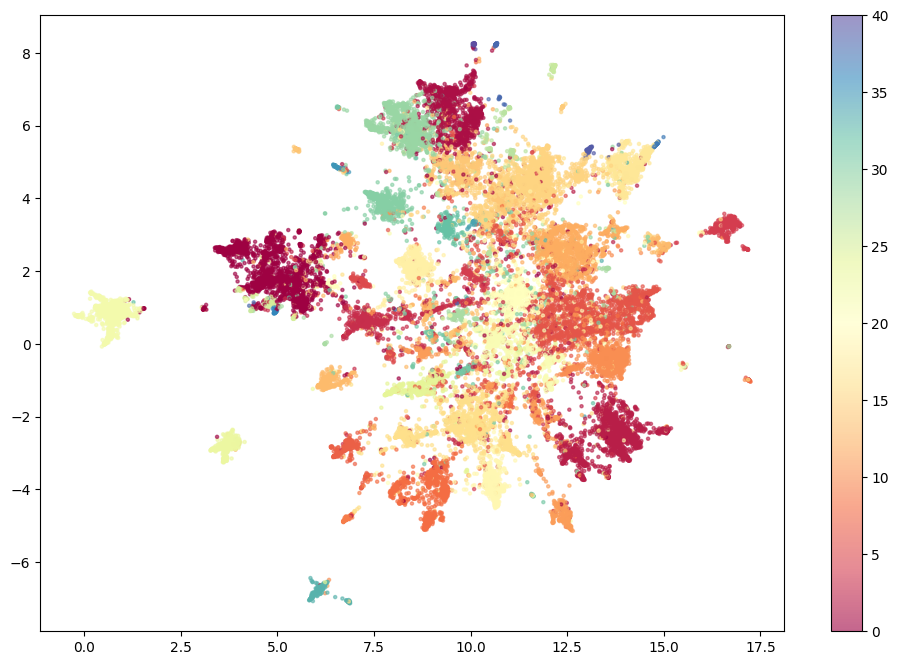

In [169]:
# 5. 可视化结果 (使用PCA的前两个主成分)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(matrix_2d[:, 0], matrix_2d[:, 1], 
                     c=cluster_labels, cmap='Spectral', alpha=0.6, s=5)
plt.colorbar(scatter)
# plt.xlabel('PC1 (解释方差: {:.1f}%)'.format(pca.explained_variance_ratio_[0]*100))
# plt.ylabel('PC2 (解释方差: {:.1f}%)'.format(pca.explained_variance_ratio_[1]*100))
# plt.title(f'Louvain Clustering (PCA50+KNN, k={n_neighbors}, {n_clusters} communities)')
# plt.show()

## split dataset in clusters

In [170]:
cluster_labels.shape

(27295,)

In [171]:
def split_data_by_patient_id_with_clusters(
    data_df, 
    #patient_id_col='node1',
    patient_id=None,
    cluster_labels=None, 
    ratios=[1, 2, 7], 
    random_seed=42
):
    """
    根据病人ID和聚类标签将数据框按指定比例划分为多个子集，
    确保每个聚类内部按比例划分，且各子集间病人ID无重叠
    
    参数:
    data_df: pandas.DataFrame - 输入的数据框
    #patient_id_col: str - 病人ID所在的列名，默认为'node1'
    cluster_labels: array-like - 病人的聚类标签，默认为None
    ratios: list - 划分比例，默认为[1, 2, 7] (对应test:val:train)
    random_seed: int - 随机数种子，确保结果可重现
    
    返回:
    tuple - 划分后的多个数据框 (test_df, val_df, train_df)
    """
    
    # 设置随机种子
    np.random.seed(random_seed)
    
    # 确保聚类标签存在
    if cluster_labels is None:
        raise ValueError("必须提供cluster_labels参数")
    
    if patient_id is None:
        raise ValueError("必须提供patient_id参数")
    
    # 为每个患者分配聚类标签
    patient_clusters = pd.DataFrame({
        'patient_id': patient_id,
        'cluster': cluster_labels
    })
    
    # 初始化各集合的患者ID列表
    test_patients = []
    val_patients = []
    train_patients = []
    
    # 对每个聚类进行划分
    for cluster_id in patient_clusters['cluster'].unique():
        # 获取当前聚类的患者ID
        cluster_patients = patient_clusters[
            patient_clusters['cluster'] == cluster_id
        ]['patient_id'].values
        
        # 计算各部分应占的患者数量
        total_patients = len(cluster_patients)
        ratio_sum = sum(ratios)
        
        # 按比例计算各集合的患者数量
        test_size = round(total_patients * ratios[0] / ratio_sum)
        val_size = round(total_patients * ratios[1] / ratio_sum)
        train_size = total_patients - test_size - val_size
        
        # 随机打乱患者ID
        shuffled_ids = np.random.permutation(cluster_patients)
        
        # 划分患者ID
        test_ids = shuffled_ids[:test_size]
        val_ids = shuffled_ids[test_size:test_size+val_size]
        train_ids = shuffled_ids[test_size+val_size:]
        
        # 添加到总体集合
        test_patients.extend(test_ids)
        val_patients.extend(val_ids)
        train_patients.extend(train_ids)
    
    # 根据患者ID划分数据
    # test_df = data_df[data_df[patient_id_col].isin(test_patients)]
    # val_df = data_df[data_df[patient_id_col].isin(val_patients)]
    # train_df = data_df[data_df[patient_id_col].isin(train_patients)]
    
    # 构建test_df：移除node1或node2中包含val_patients或train_patients的行
    test_df = data_df[~((data_df['node1'].isin(val_patients) | data_df['node2'].isin(val_patients)) | 
                       (data_df['node1'].isin(train_patients) | data_df['node2'].isin(train_patients)))]
    
    # 构建val_df
    val_df = data_df[~((data_df['node1'].isin(test_patients) | data_df['node2'].isin(test_patients)) | 
                       (data_df['node1'].isin(train_patients) | data_df['node2'].isin(train_patients)))]
    # 构建train_df
    train_df = data_df[~((data_df['node1'].isin(test_patients) | data_df['node2'].isin(test_patients)) | 
                       (data_df['node1'].isin(val_patients) | data_df['node2'].isin(val_patients)))]
    
    return test_df, val_df, train_df

In [172]:
test_data, val_data, train_data = split_data_by_patient_id_with_clusters(
    data_df=merged_df_long, 
    #patient_id_col='node1',
    patient_id=select_embeddings_dict_keys,
    cluster_labels=cluster_labels, 
    ratios=[1, 2, 7], 
    random_seed=42
)

In [173]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1192515, 3)
(481266, 3)
(351655, 3)


In [174]:
merged_df_long.shape

(1649410, 3)

In [175]:
train_data.to_csv('../Data/train_data_splitClusters.txt', sep='\t', na_rep='nan', index=False)
val_data.to_csv('../Data/val_data_splitClusters.txt', sep='\t', na_rep='nan', index=False)
test_data.to_csv('../Data/test_data_splitClusters.txt', sep='\t', na_rep='nan', index=False)

In [176]:
prepareInputData(adj_path='../Data/train_data_splitClusters.txt',
                 graph_path_save='../Data/train_graph_splitClusters.pkl',
                 protein_embeddings_path='../Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='../Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='../Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='../Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='../Data/UKB_node_feature_gpt_train_splitClusters.npy'
                     )

矩阵形状: (41184, 1536)


In [177]:
prepareInputData(adj_path='../Data/val_data_splitClusters.txt',
                 graph_path_save='../Data/val_graph_splitClusters.pkl',
                 protein_embeddings_path='../Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='../Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='../Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='../Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='../Data/UKB_node_feature_gpt_val_splitClusters.npy'
                     )

矩阵形状: (27535, 1536)


In [178]:
prepareInputData(adj_path='../Data/test_data_splitClusters.txt',
                 graph_path_save='../Data/test_graph_splitClusters.pkl',
                 protein_embeddings_path='../Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='../Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='../Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='../Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='../Data/UKB_node_feature_gpt_test_splitClusters.npy'
                     )

矩阵形状: (24810, 1536)


In [179]:
test_data, val_data, train_data = split_data_by_patient_id_with_clusters(
    data_df=merged_df_long, 
    #patient_id_col='node1',
    patient_id=select_embeddings_dict_keys,
    cluster_labels=cluster_labels, 
    ratios=[1, 7, 2], 
    random_seed=42
)

In [180]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(482503, 3)
(1191901, 3)
(351655, 3)


In [181]:
merged_df_long.shape

(1649410, 3)

In [182]:
train_data.to_csv('../Data/train_data_splitClusters_0530.txt', sep='\t', na_rep='nan', index=False)
val_data.to_csv('../Data/val_data_splitClusters_0530.txt', sep='\t', na_rep='nan', index=False)
test_data.to_csv('../Data/test_data_splitClusters_0530.txt', sep='\t', na_rep='nan', index=False)

In [183]:
prepareInputData(adj_path='../Data/train_data_splitClusters_0530.txt',
                 graph_path_save='../Data/train_graph_splitClusters_0530.pkl',
                 protein_embeddings_path='../Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='../Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='../Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='../Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='../Data/UKB_node_feature_gpt_train_splitClusters_0530.npy'
                     )

矩阵形状: (27536, 1536)


In [184]:
prepareInputData(adj_path='../Data/val_data_splitClusters_0530.txt',
                 graph_path_save='../Data/val_graph_splitClusters_0530.pkl',
                 protein_embeddings_path='../Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='../Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='../Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='../Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='../Data/UKB_node_feature_gpt_val_splitClusters_0530.npy'
                     )

矩阵形状: (41183, 1536)


In [185]:
prepareInputData(adj_path='../Data/test_data_splitClusters_0530.txt',
                 graph_path_save='../Data/test_graph_splitClusters_0530.pkl',
                 protein_embeddings_path='../Data/gpt_protein_embeddings_dict.pkl',
                 gpt_embeddings_path='../Data/gpt_embeddings_dict.pkl',
                 metabolite_embeddings_path='../Data/metabolite_embeddings_dict.pkl',
                 icd10_embeddings_path='../Data/icd10_embeddings_dict.pkl',
                 UKB_node_feature_save='../Data/UKB_node_feature_gpt_test_splitClusters_0530.npy'
                     )

矩阵形状: (24810, 1536)
